<a href="https://colab.research.google.com/github/eunsun53/ML_proj/blob/main/imbalanced_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalanced Classification 
> 1. Undersampling 
> 2. Oversampling 
> 3. Weight Loss

* dataset: kaggle 신용카드 부정 행위 데이터셋 

[tensorflow 튜토리얼](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [1]:
#드라이브-코랩 연동 
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
cd /content/gdrive/MyDrive/dataset/credit_card_fraud

/content/gdrive/MyDrive/dataset/credit_card_fraud


In [3]:
!unzip credit_card_fraud.zip

Archive:  credit_card_fraud.zip
  inflating: creditcard.csv          


In [5]:
import tensorflow as tf 
from tensorflow import keras 
import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
raw_df = pd.read_csv('creditcard.csv')

In [8]:
raw_df.head() # class 0: 정상, 1: fraud 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print("total: {} \npositive: {} ({:.2f}% of total)".format(total, pos, 100*(pos/total)))

total: 284807 
positive: 492 (0.17% of total)


In [17]:
# Time 열 제거 및 Amount 로그화 
cleaned_df = raw_df.copy()
cleaned_df.pop('Time')

eps = 0.001
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [18]:
#train, test data 나누기 
train_df, test_df = train_test_split(cleaned_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0 # class가 1이면(fraud) true 
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [20]:
# 데이터 표준 정규화 
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# np.clip(arr, min, max): arr에서 min값보다 작은 값은 min값으로, max값보다 큰 값은 max 값으로 바꿈 
train_features = np.clip(train_features, -5, 5) 
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [21]:
#모델 building 
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [35]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [33]:
model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                480       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [34]:
#EPOCHS = 100
BATCH_SIZE = 2048
hist = model.fit(train_features, train_labels, 
                 batch_size = BATCH_SIZE,
                 epochs = 20,
                 validation_data = (val_features, val_labels),
                 verbose = 0)


In [24]:
model.predict(train_features[:10])

array([[0.14400634],
       [0.2627493 ],
       [0.06237361],
       [0.1348438 ],
       [0.23348197],
       [0.38845325],
       [0.31918335],
       [0.06063139],
       [0.3441718 ],
       [0.22854254]], dtype=float32)

In [31]:
print(hist.history['accuracy'])

# 클래스 가중치 주기 

In [27]:
# 더 적은 클래스에 대해서 더 큰 가중치를 둬서 더 적은 클래스에도 큰 관심을 기울임 
weight_for_0 = (1 / neg)*(total / 2.0)
weight_for_1 = (1 / pos)*(total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('weight for 0: {:.2f}'.format(weight_for_0))
print('weight for 1: {:.2f}'.format(weight_for_1))

weight for 0: 0.50
weight for 1: 289.44


In [28]:
import tempfile

In [29]:
# 가중치 저장 후 학습 전에 각 모델에 로드 후 사용  
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

In [36]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = 20,
    callbacks = [early_stopping],
    validation_data = (val_features, val_labels),
    class_weight = class_weight # class weight 적용한다는 param
)

Epoch 1/20
90/90 [==============================] - 6s 25ms/step - loss: 0.6322 - tp: 263.0000 - fp: 384.0000 - tn: 227066.0000 - fn: 132.0000 - accuracy: 0.9977 - precision: 0.4065 - recall: 0.6658 - auc: 0.9412 - prc: 0.5570 - val_loss: 0.0125 - val_tp: 83.0000 - val_fp: 218.0000 - val_tn: 45253.0000 - val_fn: 15.0000 - val_accuracy: 0.9949 - val_precision: 0.2757 - val_recall: 0.8469 - val_auc: 0.9606 - val_prc: 0.7923
Epoch 2/20
90/90 [==============================] - 1s 7ms/step - loss: 0.4856 - tp: 195.0000 - fp: 1625.0000 - tn: 180354.0000 - fn: 102.0000 - accuracy: 0.9905 - precision: 0.1071 - recall: 0.6566 - auc: 0.9591 - prc: 0.5186 - val_loss: 0.0221 - val_tp: 85.0000 - val_fp: 462.0000 - val_tn: 45009.0000 - val_fn: 13.0000 - val_accuracy: 0.9896 - val_precision: 0.1554 - val_recall: 0.8673 - val_auc: 0.9687 - val_prc: 0.7984
Epoch 3/20
90/90 [==============================] - 1s 8ms/step - loss: 0.3372 - tp: 216.0000 - fp: 2548.0000 - tn: 179431.0000 - fn: 81.0000 - accu

In [39]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='red', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='red', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

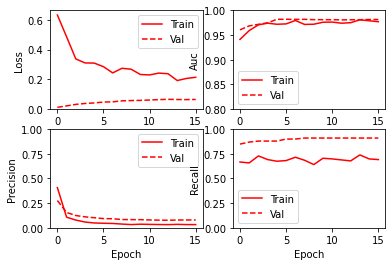

In [40]:
plot_metrics(weighted_history)

# Oversampling 

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [45]:
print(len(neg_features), len(pos_features))

181979 297


In [43]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices] # neg 데이터 갯수만큼 pos 데이터에서 임의로 선택 복제 
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181979, 29)

In [46]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis = 0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis = 0)
print(resampled_features.shape)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]


(363958, 29)


In [50]:
# 오버샘플링 데이터 학습 
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0]) # bias 는 0으로 초기화 (데이터셋이 balanced 되어있음)

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs = 20,
    callbacks = [early_stopping],
    validation_data = val_ds
)

Epoch 1/20
11374/11374 [==============================] - 32s 3ms/step - loss: 0.1123 - tp: 342003.0000 - fp: 19039.0000 - tn: 377687.0000 - fn: 9390.0000 - accuracy: 0.9620 - precision: 0.9473 - recall: 0.9733 - auc: 0.9928 - prc: 0.9918 - val_loss: 0.0332 - val_tp: 87.0000 - val_fp: 688.0000 - val_tn: 44783.0000 - val_fn: 11.0000 - val_accuracy: 0.9847 - val_precision: 0.1123 - val_recall: 0.8878 - val_auc: 0.9655 - val_prc: 0.7886
Epoch 2/20
11374/11374 [==============================] - 23s 2ms/step - loss: 0.0599 - tp: 181264.0000 - fp: 6572.0000 - tn: 175407.0000 - fn: 715.0000 - accuracy: 0.9800 - precision: 0.9650 - recall: 0.9961 - auc: 0.9965 - prc: 0.9959 - val_loss: 0.0212 - val_tp: 84.0000 - val_fp: 333.0000 - val_tn: 45138.0000 - val_fn: 14.0000 - val_accuracy: 0.9924 - val_precision: 0.2014 - val_recall: 0.8571 - val_auc: 0.9571 - val_prc: 0.7708
Epoch 3/20
11374/11374 [==============================] - 23s 2ms/step - loss: 0.0491 - tp: 181621.0000 - fp: 5394.0000 - tn: 

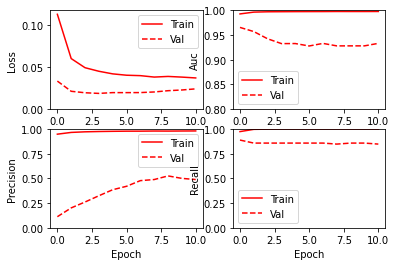

In [51]:
plot_metrics(resampled_history)